In [1]:
import sounddevice as sd
import soundfile as sf
import os
import scipy
import matplotlib.pyplot as plt
from time import time
from scipy.signal import stft
import pyroomacoustics as pra
import numpy as np
from scipy.signal import butter, lfilter, freqz
import IPython
import pyroomacoustics as pra

%matplotlib inline

In [2]:
# Set up parameters for recording
duration_sec = 5
sample_rate = 44100
channels = 2
sr = sample_rate

In [3]:
def display_left_right(audio_data):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(2, 1, 1)
    plt.plot(audio_data[:,0], label='left')
    plt.plot(audio_data[:,1], label='right')

    plt.subplot(2, 1, 2)
    plt.plot(audio_data[:,0] - audio_data[:,1], label='diff')
    plt.legend()
    plt.show()

def compute_doa_grid_val(stereo_input, fft_length=512, sampling_freq=48000, inter_mic_dist=0.16):
    R = np.array([[0, inter_mic_dist], [0, 0]])

    # compute the STFT for each channel
    _, _, Zxx_1 = stft(stereo_input[:,0], fs=sampling_freq, nperseg=fft_length)
    _, _, Zxx_2 = stft(stereo_input[:,1], fs=sampling_freq, nperseg=fft_length)

    Zxx = np.stack((Zxx_1, Zxx_2), axis=0)


    doa = pra.doa.NormMUSIC(R, fs = sr, nfft=fft_length)
    doa.locate_sources(Zxx)
    return doa.grid.values

def compute_doa_azimuth(stereo_input, fft_length=512, sampling_freq=48000, inter_mic_dist=0.16):
    R = np.array([[0, inter_mic_dist], [0, 0]])

    # compute the STFT for each channel
    _, _, Zxx_1 = stft(stereo_input[:,0], fs=sampling_freq, nperseg=fft_length)
    _, _, Zxx_2 = stft(stereo_input[:,1], fs=sampling_freq, nperseg=fft_length)

    Zxx = np.stack((Zxx_1, Zxx_2), axis=0)


    doa = pra.doa.NormMUSIC(R, fs = sr, nfft=fft_length)
    doa.locate_sources(Zxx)
    return doa.grid.azimuth

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def doa_from_audio(audio_data, window_size=30000, step_size=500, lowpass_doa = True, detection_threshold = 300):
    """Returns the angle of the source in degrees (-90 to 90)"""

    spatial_resp = []

    for i in range(int(window_size/2), int(audio_data.shape[0]-window_size/2), step_size):
        #print(i)
        window = audio_data[int(i-window_size/2):int(i+window_size/2)]
        if np.mean(np.abs(window)) < detection_threshold: #peak detection - 300 is forged value, will need adaption when using the final hardware
            spatial_resp.append(0)
            continue
        temp = compute_doa_grid_val(window)
        temp[180:] = 0 # we only take the first half of the spectrum
        angle = (np.argmax(temp))
        angle = angle-90
        spatial_resp.append(angle)

    # lowpass filter to smooth out the response
    if lowpass_doa:
        spatial_resp = butter_lowpass_filter(spatial_resp, 100, 6000)

    return spatial_resp

def plot_doa_from_audio(audio_data, window_size=30000, step_size=500, lowpass_doa = True, detection_threshold = 300):
    spatial_resp = doa_from_audio(audio_data, window_size, step_size, lowpass_doa, detection_threshold)

    # compute new index for plotting
    index = np.zeros_like(spatial_resp)
    for i in range(len(spatial_resp)):
        index[i] = i*step_size
    
    fig,ax = plt.subplots()
    fig.suptitle("audio and doa")

    ax.plot(audio_data[:,0], color = "blue")
    ax.set_ylabel("amplitude of the audio signal", color = "blue")
    ax.set_xlabel("time (samples)")

    ax2 = ax.twinx()
    ax2.plot(index, spatial_resp, color = "orange")
    ax2.set_ylabel("doa azimuth (deg)", color = "orange")
    plt.plot(spatial_resp)
    plt.show()

In [4]:
sd.query_devices()

  0 HD-Audio Generic: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
  1 Sandberg 126-20: USB Audio (hw:1,0), ALSA (0 in, 2 out)
  2 Sandberg 126-20: USB Audio (hw:3,0), ALSA (0 in, 2 out)
  3 hdmi, ALSA (0 in, 8 out)
  4 pulse, ALSA (32 in, 32 out)
* 5 default, ALSA (32 in, 32 out)

important both mics should not be used by the system !

choose voicemeter ouput = 3

In [5]:
stream = sd.InputStream(device=15, channels=32, samplerate=sample_rate)
record = False
record_display = True

PortAudioError: Error querying device 15

In [9]:
samples, _ = stream.read(frames = 1)

PortAudioError: Stream is stopped [PaErrorCode -9983]

In [111]:
if record:
    if os.path.exists('voicemeter.wav'):
        os.remove('voicemeter.wav')

    # Record audio
    print('Recording...')
    with sf.SoundFile('voicemeter.wav', mode='x', samplerate=sample_rate, channels=channels) as file:
        with stream:
            start_time = time()
            while time() - start_time < duration_sec:
                file.write(stream.read(int(0.1 * sample_rate))[0])


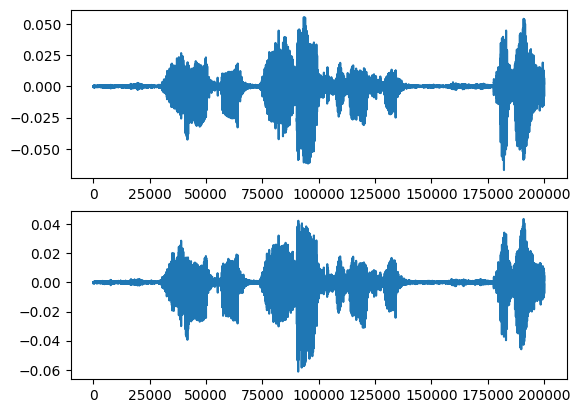

In [112]:
if record_display:
    with stream:
        samples, _ = stream.read(200000)
    
    if os.path.exists('voicemeter.wav'):
        os.remove('voicemeter.wav')
    
    with sf.SoundFile('voicemeter.wav', mode='x', samplerate=sample_rate, channels=channels) as file:
            file.write(samples)

    plt.subplot(211)
    plt.plot(samples[:,0])

    plt.subplot(212)
    plt.plot(samples[:,1])

    plt.show()

DOA from wav file

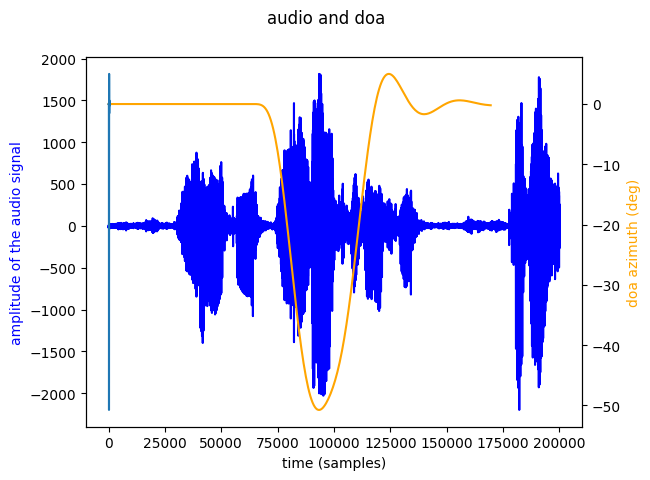

In [113]:
PATH03 = "voicemeter.wav"
sr03,data03= scipy.io.wavfile.read(PATH03)
plot_doa_from_audio(data03, window_size= 30000, lowpass_doa=True, detection_threshold=200)

DOA directly from samples

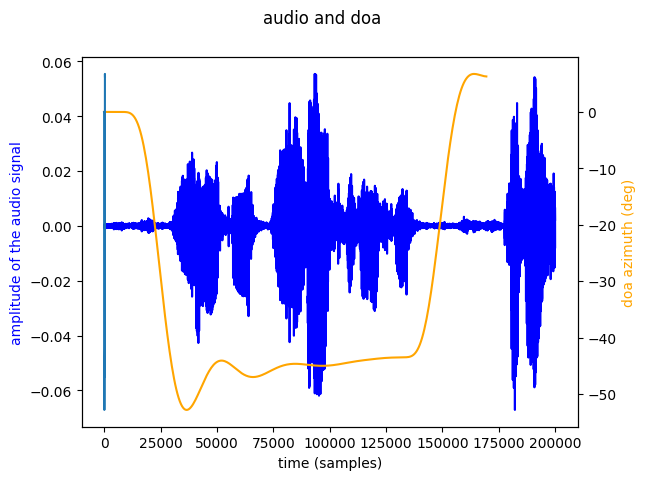

In [114]:
plot_doa_from_audio(samples, lowpass_doa=True, detection_threshold=0.001)

No difference between the two

No sound
No sound
No sound
No sound
No sound
No sound
No sound
-48
No sound
No sound
No sound
-48
-47
No sound
No sound
No sound
No sound
No sound
-42
-50
0
0
0
-1
-55
-58
-54
-49
No sound
No sound
-45
No sound
No sound
No sound
-47
No sound
No sound
No sound
No sound
No sound
11
No sound
No sound
No sound
No sound
No sound
-14
-90
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
-77
37
No sound
No sound
-90
No sound
No sound
No sound
No sound
-56
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
-47
No sound
No sound
No sound
-44
-45
No sound
No sound
No sound
No sound
-45
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound
-3
No sound
No sound
No sound
-3
-5
-4
-4
No sound
No sound
No sound
No sound
No sound
No sound
No sound
No sound

KeyboardInterrupt: 

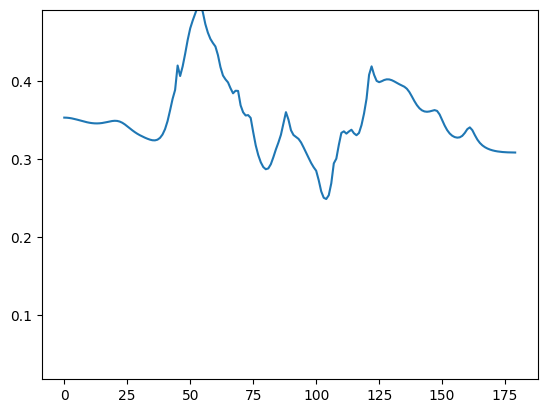

In [55]:
# Start recording
n_samples = 20000
sr = 44100
sampling_freq = 44100
fft_length = 512
R = np.array([[0, 0.16], [0, 0]])


it = 0
with stream:
    while True:
        samples = []
        # for _ in range(n_samples):
        #     data, _ = stream.read(1)
        #     samples.append(data)
        # samples = np.squeeze(np.array(samples))
        
        samples, _ = stream.read(n_samples)

        if np.mean(np.abs(samples)) > 0.005 :
            _, _, Zxx_1 = stft(samples[:,0], fs=sampling_freq, nperseg=fft_length)
            _, _, Zxx_2 = stft(samples[:,1], fs=sampling_freq, nperseg=fft_length)
            Zxx = np.stack((Zxx_1, Zxx_2), axis=0)
            doa = pra.doa.NormMUSIC(R, fs = sr, nfft=fft_length)
            doa.locate_sources(Zxx)
            temp = doa.grid.values
            temp[180:] = 0 # we only take the first half of the spectrum
            angle = (np.argmax(temp))
            angle = angle-90
            print(angle)
            it = it + 1
        else:
            print("No sound")


### Back to cross correaltion

fuck MUSIC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

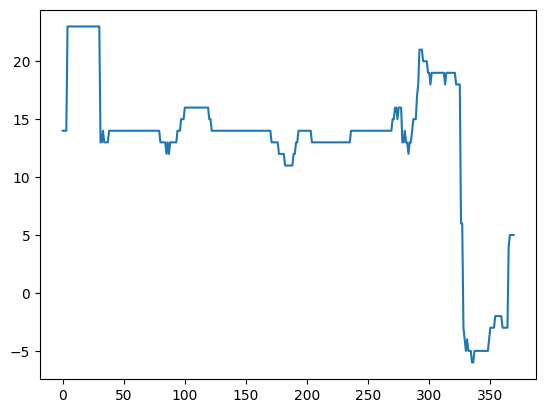

In [121]:
corr = scipy.signal.correlate(samples[:,0], samples[:,1])

window_size = 15000
step_size = 500

diffs = []

for i in range(int(window_size/2), int(samples.shape[0]-window_size/2), step_size):
        #print(i)
        window = samples[int(i-window_size/2):int(i+window_size/2)]
        corr = scipy.signal.correlate(window[:,0], window[:,1])
        diff = np.argmax(corr)-window_size
        diffs.append(diff)
plt.plot(diffs)

In [9]:
# Start recording
n_samples = 15000
sr = 44100
sampling_freq = 44100
fft_length = 512
R = np.array([[0, 0.16], [0, 0]])
thresh = 13

stream = sd.InputStream(device=3, channels=channels, samplerate=sample_rate)

it = 0
calib = []
with stream:
    while True:
        samples, _ = stream.read(n_samples)
        offset = np.argmax(scipy.signal.correlate(samples[:,0], samples[:,1]))-n_samples
        if it < 5:
            calib.append(offset)
            it = it + 1
        else:
            if it == 5:
                zero = np.mean(calib)
                print(f"center offset: {zero}")
                it = it + 1
            if offset < zero-thresh:
                print("gauche")
            elif offset > zero+thresh:
                print("droite")
            else:
                print("indiscernable")
        


Expression 'parameters->channelCount <= maxChans' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1514
Expression 'ValidateParameters( inputParameters, hostApi, StreamDirection_In )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 2818


PortAudioError: Error opening InputStream: Invalid number of channels [PaErrorCode -9998]

In [126]:
calib

[]